<a href="https://colab.research.google.com/github/raaraya1/Personal-Proyects/blob/main/Canales%20de%20Youtube/Sentdex/Pytorch/Taller8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import zipfile
from tqdm import tqdm
from google.colab import files

In [ ]:
#cargar
upload = files.upload()

Saving training_data.npy to training_data.npy


In [ ]:
training_data = np.load('training_data.npy', allow_pickle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.conv3 = nn.Conv2d(64, 128, 5)

    x = torch.randn(50, 50).view(-1, 1, 50, 50)
    self._to_linear = None
    self.convs(x)

    self.fc1 = nn.Linear(self._to_linear, 512)
    self.fc2 = nn.Linear(512, 2)

  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

    #print(x[0].shape)
    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x
  
  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return F.softmax(x, dim=1)

net = Net()


In [ ]:

import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

399


In [ ]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))



3596
399


In [ ]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [ ]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
BATCH_SIZE = 100
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
  BATCH_SIZE = 100
  EPOCHS = 3
  for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):   
      batch_X =train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
      batch_y =train_y[i:i+BATCH_SIZE]

      batch_X, batch_y = batch_X.to(device), batch_y.to(device)

      net.zero_grad()
      outputs = net(batch_X)
      loss = loss_function(outputs, batch_y)
      loss.backward()
      optimizer.step()
    print(loss)

train(net)


 36%|███▌      | 13/36 [00:00<00:00, 122.36it/s]

tensor(0.2446, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 13/36 [00:00<00:00, 122.96it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MseLossBackward>)


100%|██████████| 36/36 [00:00<00:00, 118.78it/s]


tensor(0.2190, device='cuda:0', grad_fn=<MseLossBackward>)


In [ ]:
def test(net):
  correct = 0
  total = 0
  with torch.no_grad():
    for i in tqdm(range(len(test_X))):
      real_class = torch.argmax(test_y[i]).to(device)
      net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]      
      predicted_class = torch.argmax(net_out)

      if predicted_class == real_class:
        correct += 1
      total += 1

  print('accuracy: ', round(correct/total, 3))



In [ ]:
def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)

            matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
            in_sample_acc = matches.count(True)/len(matches)

            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(loss)
        print("In-sample acc:",round(in_sample_acc, 2))

train(net)

 22%|██▏       | 8/36 [00:00<00:00, 71.37it/s]

tensor(0.2188, device='cuda:0', grad_fn=<MseLossBackward>)
In-sample acc: 0.64


 19%|█▉        | 7/36 [00:00<00:00, 69.85it/s]

tensor(0.2139, device='cuda:0', grad_fn=<MseLossBackward>)
In-sample acc: 0.67


100%|██████████| 36/36 [00:00<00:00, 67.91it/s]

tensor(0.2000, device='cuda:0', grad_fn=<MseLossBackward>)
In-sample acc: 0.7


In [ ]:
def fwd_pass(X, y, train=False):
  if train:
    net.zero_grad()
  outputs = net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss


In [ ]:
import numpy as np

def test(size=32):
  random_start = np.random.randint(len(test_X)-size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
  return val_acc, val_loss

val_acc, val_loss = test(size=100)
print(val_acc, val_loss)

test(100)

0.63 tensor(0.2278, device='cuda:0', grad_fn=<MseLossBackward>)


(0.63, tensor(0.2199, device='cuda:0', grad_fn=<MseLossBackward>))

In [ ]:
import time

MODEL_NAME = f'model-{int(time.time())}'

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
  BATCH_SIZE = 100
  EPOCHS = 5
  with open('model.log', 'a') as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        if i%50 == 0:
          val_acc, val_loss = test(size=100)
          f.write(f'{MODEL_NAME}, {round(time.time(), 3)}, {round(float(acc), 2)}, {round(float(loss), 4)}, {round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n')

train()


 11%|█         | 4/36 [00:00<00:00, 34.10it/s]

model-1612645519


100%|██████████| 36/36 [00:00<00:00, 42.39it/s]


val_losses:  [0.2556, 0.2487, 0.2483, 0.2551, 0.2484, 0.2529, 0.2515, 0.2513, 0.2489, 0.2488, 0.249, 0.2489, 0.2495, 0.2508, 0.2496, 0.2491, 0.2492, 0.2496, 0.2497, 0.2487, 0.2482, 0.2471, 0.2481, 0.248, 0.2499, 0.2447, 0.2461, 0.2437, 0.2456, 0.2456, 0.2423, 0.2392, 0.2546, 0.2547, 0.2548, 0.2455, 0.2421, 0.247, 0.2457, 0.247, 0.2547, 0.2466, 0.2492, 0.2491, 0.2494, 0.245, 0.243, 0.2452, 0.2497, 0.2405, 0.2495, 0.2496, 0.2477, 0.2423, 0.2454, 0.241, 0.2467, 0.2466, 0.2451, 0.2464, 0.2467, 0.2385, 0.2514, 0.2405, 0.2385, 0.2326, 0.2564, 0.233, 0.2631, 0.2719, 0.2719, 0.2447, 0.2378, 0.2627, 0.2722, 0.2601, 0.2678, 0.244, 0.2347, 0.2363, 0.2382, 0.2386, 0.2444, 0.2363, 0.239, 0.2424, 0.2431, 0.248, 0.2439, 0.2428, 0.2295, 0.2362, 0.239, 0.238, 0.239, 0.2392, 0.2314, 0.2353, 0.2281, 0.2364, 0.2365, 0.2382, 0.2285, 0.2324, 0.2423, 0.2303, 0.2243, 0.2351, 0.2347, 0.2253, 0.2586, 0.2328, 0.2324, 0.2359, 0.2325, 0.2183, 0.2295, 0.2305, 0.2291, 0.2321, 0.2264, 0.2327, 0.2284, 0.2228, 0.2213, 

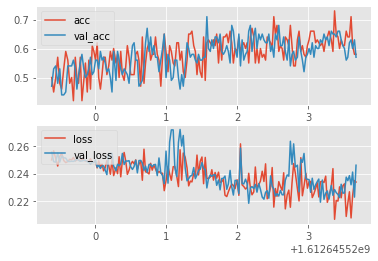

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

model_name = 'model-1612645519'

def create_acc_loss_graph(model_name):
  contents = open('model.log', 'r').read().split('\n')

  times = []
  accuracies = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    
    if model_name in c:
      name, timestamp, acc, loss, val_acc, val_loss = c.split(',')

      times.append(float(timestamp))
      accuracies.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))

  #plt.plot(times, accuracies)
  #plt.show()

  print('val_losses: ', val_losses)

  fig = plt.figure()
  ax1 = plt.subplot2grid((2, 1), (0, 0))
  ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

  ax1.plot(times, accuracies, label='acc')
  ax1.plot(times, val_accs, label='val_acc')
  ax1.legend(loc=2)

  ax2.plot(times, losses, label='loss')
  ax2.plot(times, val_losses, label='val_loss')
  ax2.legend(loc=2)

  #plt.plot(times, accuracies)
  plt.show()

  
  #print('times: ', times)
  #print('accuracies: ', accuracies)
  #print('losses: ', losses)

  #print('val_accs: ', val_accs)
  #print('val_losses: ', val_losses)
  #plt.show()
  

create_acc_loss_graph(model_name)

